# Imports

In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta, Variable, exp, Expression
from biogeme.models import loglogit
from biogeme.tools import likelihood_ratio_test
from biogeme.results import compile_estimation_results
from biogeme.models import loglogit,  boxcox
from biogeme.models.piecewise import piecewise_formula
from biogeme.models import lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.biogeme import BIOGEME

import pickle

import numpy as np
import os

from scipy.stats import chi2

# Data & Variables

In [ ]:
# Define the relative path to the data folder
file_path = os.path.join(os.pardir, 'lpmc01.dat')

#file_path = os.path.join(data_folder, 'lpmc01.dat')

df = pd.read_csv(file_path, sep = '\t')
df['age_normalized'] = (df['age'] - df['age'].mean()) / df['age'].std()
df['age_scaled'] = df['age'] / df['age'].max()
df['cost_driving'] = df['cost_driving_ccharge'] + df['cost_driving_fuel']
df['dur_pt'] = df['dur_pt_access'] + df['dur_pt_rail'] + df['dur_pt_int'] + df['dur_pt_bus']

# max_cost = df['cost_driving'].max() if df['cost_driving'].max() > df['cost_transit'].max() else df['cost_transit'].max()
# df['cost_driving'] = df['cost_driving']/max_cost
# df['cost_transit'] = df['cost_transit']/max_cost


database1 = db.Database('lpmc01', df)


# Define the given veriables 
dur_pt = Variable('dur_pt')
cost_driving = Variable('cost_driving')
age_scaled = Variable('age_scaled')
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')



# Define transport availability
# Assume pt, walking, cycle always available, with car availability depending on number of cars per household. From the data, 
# people without driving licenses choose driving as their mode of transport (eg. row 28). 
av_drive =  (car_ownership > 0)
av_pt =1
av_walk = 1
av_cycle = 1

variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")



# Define pt_cost (not needed)
# Original paper, page 31: "Public transport fares are determined for single trips using Oystercard/contactless payment."
# Therefore, cost_transit should already consider faretype and bus_scale

database = db.Database('lpmc01', df)
variable_names = ['dur_pt', 'cost_driving', 'age_scaled']  # Replace with your variable name
for variable_name in variable_names:
    if variable_name in database1.data.columns:
        print(f"'{variable_name}' exists in the database.")
    else:
        print(f"'{variable_name}' does NOT exist in the database.")

# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
dur_pt = dur_pt_access + dur_pt_int + dur_pt_bus + dur_pt_rail  # Public transport (external) time 

'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.
'dur_pt' exists in the database.
'cost_driving' exists in the database.
'age_scaled' exists in the database.


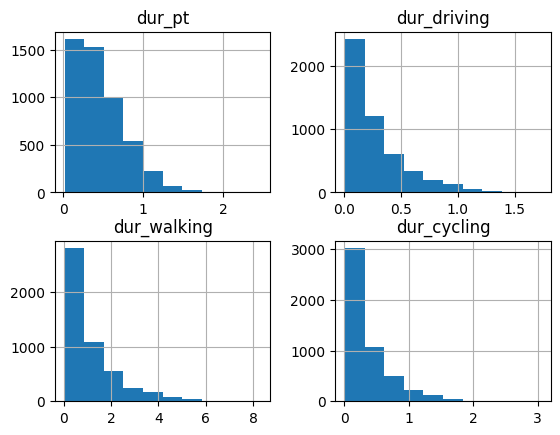

In [3]:
hist = df[['dur_pt','dur_driving','dur_walking','dur_cycling']].hist()


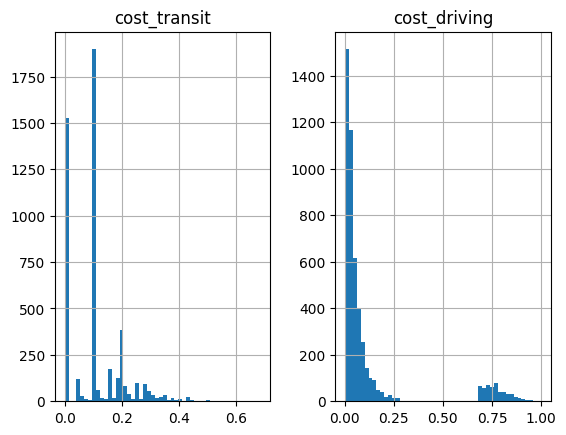

In [4]:
hist = df[['cost_transit','cost_driving']].hist(bins = 50)


# Model Definition

In [5]:
# Assume every mode of transport is available
availability_walk = 1  
availability_cycle = 1  
availability_pt = 1     
availability_drive = 1

availability = {
    1: availability_walk,   # Walking
    2: availability_cycle,  # Cycling
    3: availability_pt,     # Public Transport
    4: availability_drive   # Driving
}

# Define alternative-specific parameters for travel time
B_TIME_WALK = Beta('B_TIME_WALK', 0, None, None, 0)
B_TIME_CYCLE = Beta('B_TIME_CYCLE', 0, None, None, 0)
B_TIME_PT = Beta('B_TIME_PT', 0, None, None, 0)
B_TIME_DRIVE = Beta('B_TIME_DRIVE', 0, None, None, 0)

ASC_CYCLE = Beta('ASC_CYCLE', 0, None, None, 0)
ASC_PT = Beta('ASC_PT', 0, None, None, 0)
ASC_DRIVE = Beta('ASC_DRIVE', 0, None, None, 0)

# Define generic parameters for cost and travel time
B_COST = Beta('B_COST', 0, None, None, 0)

B_TIME_WALK_AGE = Beta('B_TIME_WALK_AGE', 0, None, None, 0)
B_TIME_CYCLE_AGE = Beta('B_TIME_CYCLE_AGE', 0, None, None, 0) 
B_TIME_PT_AGE = Beta('B_TIME_PT_AGE', 0, None, None, 0)
#B_TIME_DRIVE_AGE = Beta('B_TIME_DRIVE_AGE', 0, None, None, 0) * age_scaled

## BoxCox

In [6]:
LAMDA_COST = Beta('lambda_cost', 1, -10, 10, 0)
bx_cost_pt = boxcox(cost_transit, LAMDA_COST)
bx_cost_driving = boxcox(cost_driving, LAMDA_COST)

# Utility functions with interaction terms
# Updated utility functions with age interaction for travel time
V_WALK = (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled) * dur_walking
V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + B_TIME_CYCLE_AGE* age_scaled) * dur_cycling
V_PT = ASC_PT + B_COST * bx_cost_pt + (B_TIME_PT + B_TIME_PT_AGE* age_scaled) * dur_pt
V_DRIVE = ASC_DRIVE + B_COST * bx_cost_driving + (B_TIME_DRIVE) * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_bx = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [7]:
biogeme_bx = bio.BIOGEME(database, model_3_bx)
biogeme_bx.modelName = 'model_3_bx'

results_m3_bx = biogeme_bx.estimate()

print("Estimation results for Model 3 Box Cox:")
print(results_m3_bx.get_estimated_parameters())

Estimation results for Model 3 Box Cox:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.641632      0.200775   -23.118595  0.000000e+00
ASC_DRIVE        -2.196020      0.150158   -14.624702  0.000000e+00
ASC_PT           -2.724771      0.149510   -18.224684  0.000000e+00
B_COST           -0.015011      0.006309    -2.379141  1.735303e-02
B_TIME_CYCLE     -4.697783      0.595395    -7.890189  3.108624e-15
B_TIME_CYCLE_AGE -3.015307      1.032541    -2.920277  3.497199e-03
B_TIME_DRIVE     -6.478620      0.380956   -17.006227  0.000000e+00
B_TIME_PT        -2.748295      0.280528    -9.796869  0.000000e+00
B_TIME_PT_AGE    -1.917137      0.368561    -5.201688  1.974865e-07
B_TIME_WALK      -7.579985      0.447690   -16.931336  0.000000e+00
B_TIME_WALK_AGE  -3.467266      0.761086    -4.555683  5.221559e-06
lambda_cost       2.205097      0.232584     9.480845  0.000000e+00


In [8]:
print(results_m3_bx.print_general_statistics())

Number of estimated parameters:	12
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4768.671
Final log likelihood:	-4232.017
Likelihood ratio test for the init. model:	1073.308
Rho-square for the init. model:	0.113
Rho-square-bar for the init. model:	0.11
Akaike Information Criterion:	8488.034
Bayesian Information Criterion:	8566.24
Final gradient norm:	5.9722E-02
Nbr of threads:	16



### Test against Model 2

In [9]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [10]:
loglikehood_m3_bx = results_m3_bx.data.logLike
num_params_m3_bx = results_m3_bx.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_bx - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_bx - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Box Cox is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Box Cox over Model 2.")

Likelihood Ratio: -75.35242017381825
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
No significant improvement in Model 3 Box Cox over Model 2.


## Power Series

In [11]:
square_tt_coef = Beta('square_cost_coef', 0, None, None, 0)
cube_tt_coef = Beta('cube_cost_coef', 0, None, None, 0)

def power_series(the_variable: Expression) -> Expression:
    """Generate the expression of a polynomial of degree 3

    :param the_variable: variable of the polynomial
    """
    return (
        the_variable
        + square_tt_coef * the_variable**2
        + cube_tt_coef * the_variable * the_variable**3
    )

In [12]:
power_cost_driving = power_series(cost_driving)
power_cost_pt = power_series(cost_transit)

# Utility functions with interaction terms
V_WALK = (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled) * dur_walking
V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + B_TIME_CYCLE_AGE* age_scaled) * dur_cycling
V_PT = ASC_PT + B_COST * power_cost_pt + (B_TIME_PT + B_TIME_PT_AGE* age_scaled) * dur_pt
V_DRIVE = ASC_DRIVE + B_COST * power_cost_driving + (B_TIME_DRIVE) * dur_driving


# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_power = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [13]:
biogeme_power = bio.BIOGEME(database, model_3_power)
biogeme_power.modelName = 'model_3_power'

results_m3_power = biogeme_power.estimate()

print("Estimation results for Model 3 Power:")
print(results_m3_power.get_estimated_parameters())

Estimation results for Model 3 Power:
                     Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CYCLE        -4.640098      0.200955   -23.090276  0.000000e+00
ASC_DRIVE        -2.187713      0.150178   -14.567496  0.000000e+00
ASC_PT           -2.706702      0.149496   -18.105473  0.000000e+00
B_COST            0.004331      0.001481     2.923122  3.465404e-03
B_TIME_CYCLE     -4.812234      0.598782    -8.036701  8.881784e-16
B_TIME_CYCLE_AGE -2.991109      1.034825    -2.890450  3.846902e-03
B_TIME_DRIVE     -6.496386      0.384508   -16.895330  0.000000e+00
B_TIME_PT        -2.859336      0.284219   -10.060310  0.000000e+00
B_TIME_PT_AGE    -1.890179      0.368173    -5.133935  2.837461e-07
B_TIME_WALK      -7.610162      0.448120   -16.982424  0.000000e+00
B_TIME_WALK_AGE  -3.471456      0.763193    -4.548592  5.400593e-06
cube_cost_coef    0.043297      0.013713     3.157396  1.591852e-03
square_cost_coef -8.838426      2.617037    -3.377264  7.321072e-04


In [14]:
print(results_m3_power.print_general_statistics())

Number of estimated parameters:	13
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4373.896
Final log likelihood:	-4223.097
Likelihood ratio test for the init. model:	301.5988
Rho-square for the init. model:	0.0345
Rho-square-bar for the init. model:	0.0315
Akaike Information Criterion:	8472.193
Bayesian Information Criterion:	8556.917
Final gradient norm:	1.7569E-01
Nbr of threads:	16



### Test Against Model 2

In [15]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [16]:
loglikehood_m3_power = results_m3_power.data.logLike
num_params_m3_power = results_m3_power.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_power - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_power - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 Power is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 Power over Model 2.")

Likelihood Ratio: -57.511944083518756
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 5.991464547107979
No significant improvement in Model 3 Power over Model 2.


## Piecewise Linear

In [17]:
thresholds = [0, 1, 5, None]

beta_cost_0_5 = Beta('beta_cost_0_5', 0, None, None, 0)
beta_cost_5_10 = Beta('beta_cost_5_10', 0, None, None, 0)
beta_cost_10_more = Beta('beta_cost_10_more', 0, None, None, 0)
betas_piecewise = [beta_cost_0_5, 
                   beta_cost_5_10, 
                   beta_cost_10_more]

piecewise_cost_driving = piecewise_formula(
    'cost_driving', thresholds, betas_piecewise
)

piecewise_cost_pt = piecewise_formula(
    'cost_transit', thresholds, betas_piecewise
)


In [18]:
# Utility functions with interaction terms
V_WALK = (B_TIME_WALK + B_TIME_WALK_AGE * age_scaled) * dur_walking
V_CYCLE = ASC_CYCLE + (B_TIME_CYCLE + B_TIME_CYCLE_AGE* age_scaled) * dur_cycling
V_PT = ASC_PT + B_COST * piecewise_cost_pt + (B_TIME_PT + B_TIME_PT_AGE* age_scaled) * dur_pt
V_DRIVE = ASC_DRIVE + B_COST * piecewise_cost_driving + (B_TIME_DRIVE) * dur_driving

# Associate utility functions with the mode choice
V = {
    1: V_WALK,    # Walking
    2: V_CYCLE,   # Cycling
    3: V_PT,      # Public Transport
    4: V_DRIVE    # Driving
}

# Specify the model
model_3_piecewise = loglogit({1: V_WALK, 2: V_CYCLE, 3: V_PT, 4: V_DRIVE}, availability, travel_mode)

### Results

In [19]:
biogeme_piecewise = bio.BIOGEME(database, model_3_piecewise)
biogeme_piecewise.modelName = 'model_3_piecewise'

results_m3_piecewise = biogeme_piecewise.estimate()

print("Estimation results for Model 3 piecewise:")
print(results_m3_piecewise.get_estimated_parameters())

Estimation results for Model 3 piecewise:
                      Value   Rob. Std err    Rob. t-test  Rob. p-value
ASC_CYCLE         -4.697533   2.033185e-01  -2.310430e+01  0.000000e+00
ASC_DRIVE         -2.198467   1.505924e-01  -1.459879e+01  0.000000e+00
ASC_PT            -2.692897   1.502913e-01  -1.791785e+01  0.000000e+00
B_COST             0.000000   1.120273e-16   0.000000e+00  1.000000e+00
B_TIME_CYCLE      -5.286847   6.058362e-01  -8.726529e+00  0.000000e+00
B_TIME_CYCLE_AGE  -3.002056   1.027288e+00  -2.922312e+00  3.474431e-03
B_TIME_DRIVE      -7.738336   3.723900e-01  -2.078019e+01  0.000000e+00
B_TIME_PT         -3.329926   2.815832e-01  -1.182573e+01  0.000000e+00
B_TIME_PT_AGE     -1.899207   3.700601e-01  -5.132158e+00  2.864387e-07
B_TIME_WALK       -7.882815   4.494276e-01  -1.753968e+01  0.000000e+00
B_TIME_WALK_AGE   -3.437118   7.592668e-01  -4.526892e+00  5.985762e-06
beta_cost_0_5      0.000000  1.797693e+308   0.000000e+00  1.000000e+00
beta_cost_10_more  0.0

In [20]:
print(results_m3_piecewise.print_general_statistics())

Number of estimated parameters:	14
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4388.396
Final log likelihood:	-4280.738
Likelihood ratio test for the init. model:	215.3164
Rho-square for the init. model:	0.0245
Rho-square-bar for the init. model:	0.0213
Akaike Information Criterion:	8589.475
Bayesian Information Criterion:	8680.716
Final gradient norm:	8.0873E-02
Nbr of threads:	16



### Test Against Model 2

In [21]:
folder_path = os.path.join(os.pardir, 'Model_2')
file_path = os.path.join(folder_path, 'Model_2B.pickle')

# open a file, where you stored the pickled data
file = open(file_path, 'rb')

# dump information to that file
results_m2 = pickle.load(file)

# close the file
file.close()

In [22]:
loglikehood_m3_piecewise = results_m3_piecewise.data.logLike
num_params_m3_piecewise = results_m3_piecewise.data.nparam

loglikehood_m2 = results_m2.logLike
num_params_m2 = results_m2.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m3_piecewise - loglikehood_m2)

# Degrees of freedom
df = num_params_m3_piecewise - num_params_m2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 3 piecewise is significantly better than Model 2.")
else:
    print("No significant improvement in Model 3 piecewise over Model 2.")

Likelihood Ratio: -172.79403802439992
Degrees of Freedom: 3
Critical Chi-Square Value (0.05 significance): 7.814727903251179
No significant improvement in Model 3 piecewise over Model 2.
